## Plotting differential expression data


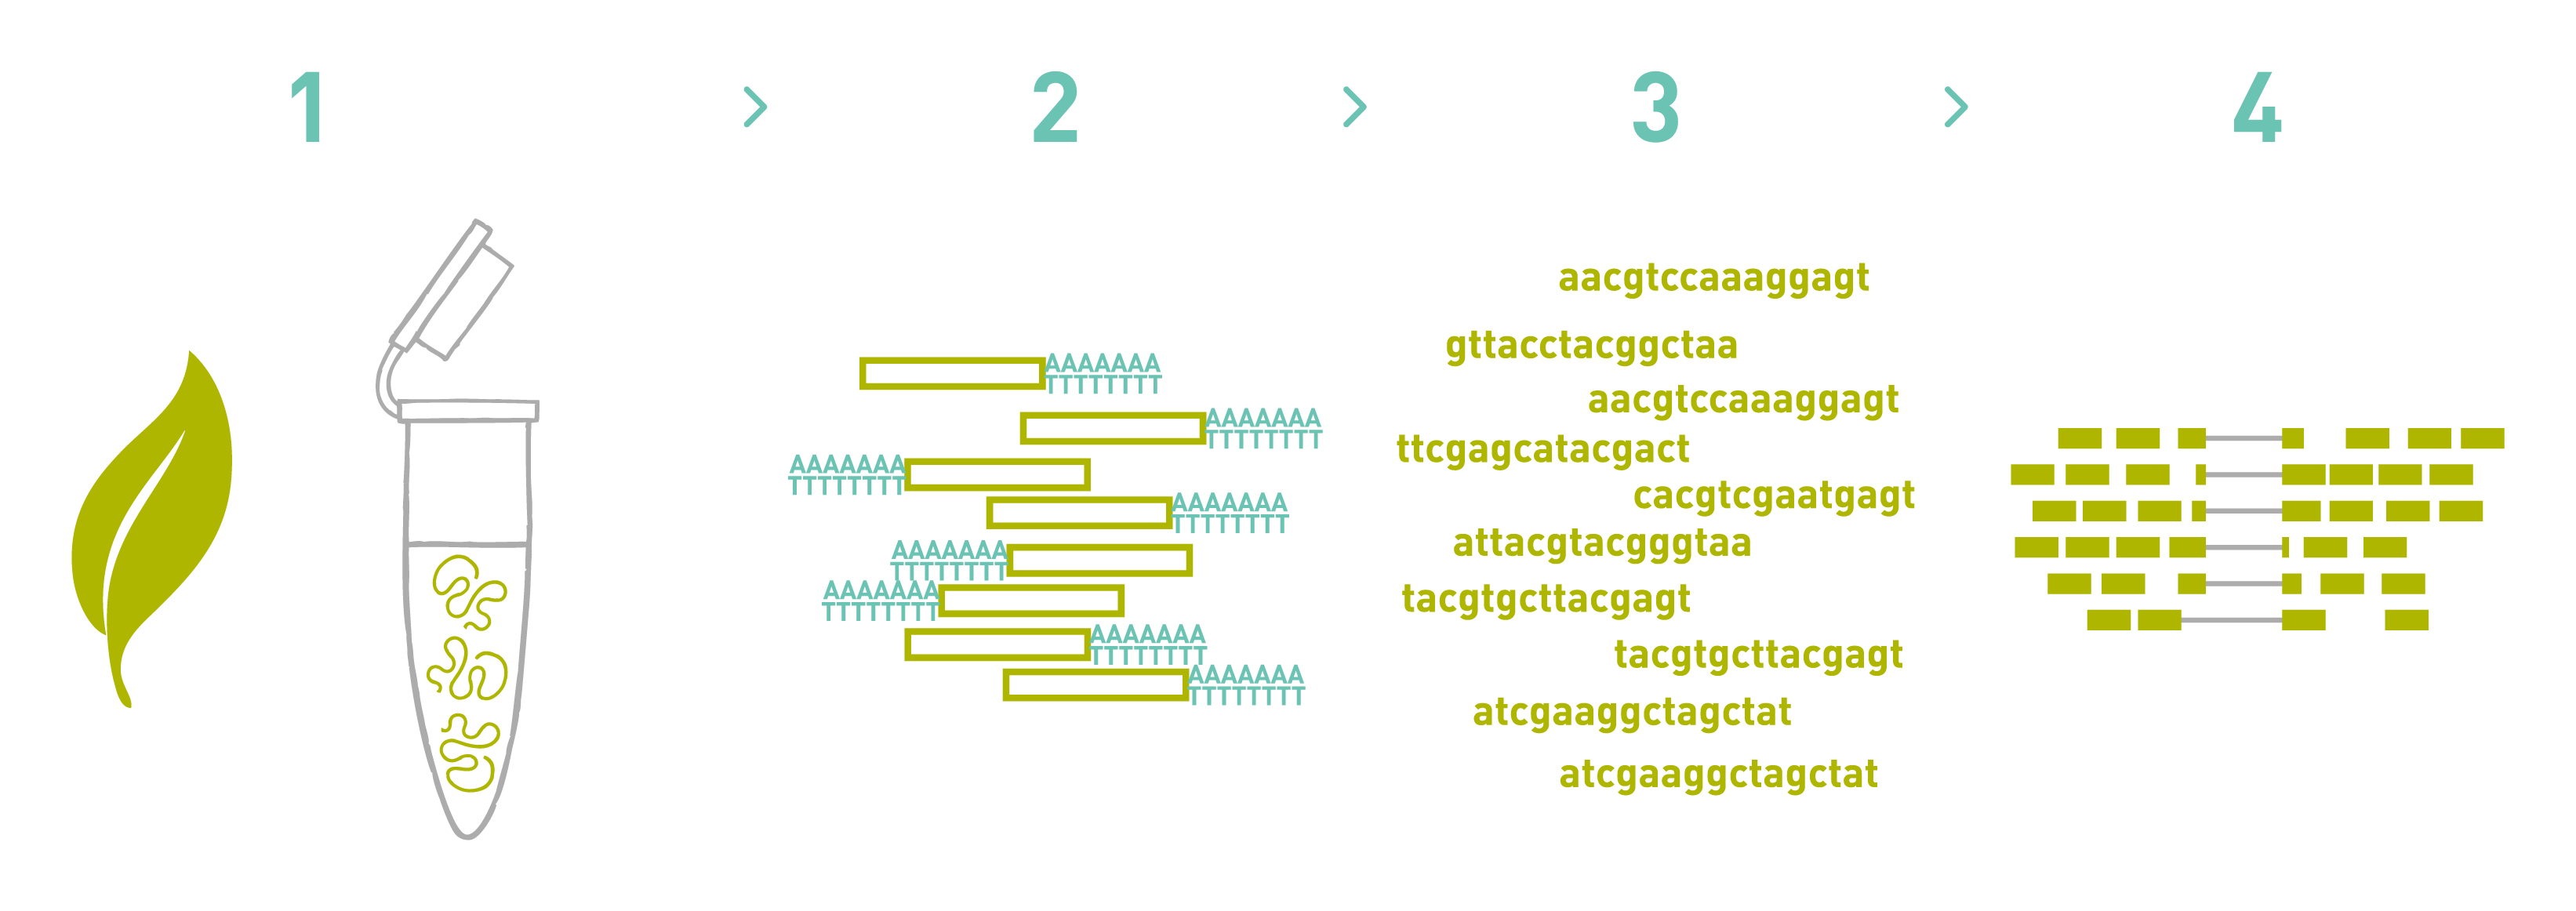

RNA sequencing is a specific type of next-generation sequencing technology that aims at quantify the amount of RNA trascripts in a certain sample. 
In current example we will look at Arabidopsis thaliana genes response to nitrate https://learn.gencore.bio.nyu.edu/rna-seq-analysis/deseq-2/. The dataset is a simple experiment where RNA is extracted from roots of independent plants and then sequenced. Two plants were treated with the control (KCl) and two samples were treated with Nitrate (KNO3). 
The typical pipeline of RNA-seq experiment is:

- Extract the RNA samples (and amplify with PCR)
- Build the libraries for the RNA-seq platform (like illumina)
- Perform the RNA-seq
- Store the results (usually FASTQ files, containing all the fragments sequenced)
- Align the FASTQ fragments to the A. thaliana genome
- Counts the fragments for each gene
- Perform a differential expression statistical analysis (in this case, with DESeq2)

We will start by loading the result of the differential expression analysis. This files contains information for each A. thaliana gene, including the differential expression fold-change between nitrate and control, as well as statistical significancy. The file has been obtained using the DESeq2 package, which uses rna-sequencing data to determine which genes are differencially expressed.

In [ ]:
# Load the DESeq2 result file
df <- read.csv("Data/DESeq.csv")

head(df)



## Fold-change and p-values

"X" are simple the genes identifiers according to the TAIR database; log2FoldChange is the differential expression between the two conditions in log2 space, usually a fold-change bigger than 1 or lower than -1 is considered interesting; padj is the adjusted p-value, an indicator of how significat is the difference in expression, it is a number between 0 and 1, usually < 0.05 is considered significant. the other columns are not important for now.

In [ ]:
library(ggplot2)

# default plots size
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

# default theme and font size
theme_set(theme_bw(base_size = 24))



In [ ]:

# Let's plot fold changes 
ggplot(df, aes(log2FoldChange)) + geom_histogram(fill="lightblue", color="black") + 
    geom_vline(xintercept = c(-1, 1), color="red", linetype="dashed", size=1)




In [ ]:
# plot the adjusted p-values
ggplot(df, aes(padj)) + geom_histogram(fill="gray", color="black")+ 
    geom_vline(xintercept = 0.05, color="red", linetype="dashed", size=1)


In [ ]:
# It looks like there are some NAs in the padj 
head(df, 10)

In [ ]:
# You can check what is NA
head( is.na(df), 10 )

In [ ]:
# We remove all the rows that contains some NA
df <- na.omit(df)

head(df, 10)

## Volcano plots

Volcano plot are useful to spot interesting genes that are both statistically significant and highly differentially expressed between conditions. https://en.wikipedia.org/wiki/Volcano_plot_(statistics). <br>
In a volcano plot, log2foldChange (you already have it) is plotted against -log10padj.



In [ ]:
# Transform padj to -log10
df$minusLogpadj <- -log(df$padj, 10)

# plot it
ggplot(df, aes(x = log2FoldChange, y = minusLogpadj)) + geom_point() 

In [ ]:
# add significant lines, center the plot and rename axis
ggplot(df, aes(x = log2FoldChange, y = minusLogpadj)) + geom_point() +
     geom_vline(xintercept = 0, color="black") +
     geom_vline(xintercept = c(-1, 1), color="red", linetype="dashed", size=1) +
     geom_hline(yintercept = -log(0.05, 10), color="red", linetype="dashed", size=1) + 
     xlim(c(-6, 6)) + xlab("log2 Fold Change") + ylab("-log10 adjusted p-value")

### Coloring interesting genes

We would like to color interesting genes (|log2foldChange| > 1 and padj < 0.05). In order to do that, let's add a new column to the data frame. We create a (True/False) factor depending on the values of that genes


In [ ]:
# Create a new column: log2foldChange lower than -1 or higher than 1 AND padj lower than 0.05
df$Interesting <- (df$log2FoldChange > 1 | df$log2FoldChange < -1) & df$padj < 0.05  
df$Interesting <- factor(df$Interesting)

head(df)

str(df)

In [ ]:
# color interesting genes
ggplot(df, aes(x = log2FoldChange, y = minusLogpadj)) + geom_point(aes(color=Interesting),  size=3) +
     geom_vline(xintercept = 0, color="black") +
     geom_vline(xintercept = c(-1, 1), color="red", linetype="dashed", size=1) +
     geom_hline(yintercept = -log(0.05, 10), color="red", linetype="dashed", size=1) + 
     xlim(c(-6, 6)) + xlab("log2 Fold Change") + ylab("-log10 adjusted p-value")
     

In [ ]:
# we want to show the name of the top10 genes

# order the data frame by padj, and only keep first 10 rows
df_top <- df[order(df$padj),]
df_top <- head(df_top, 10)

df_top


In [ ]:
# show the ID of top10 genes
ggplot(df, aes(x = log2FoldChange, y = minusLogpadj)) + geom_point(aes(color=Interesting),  size=3) +
     geom_vline(xintercept = 0, color="black") +
     geom_vline(xintercept = c(-1, 1), color="red", linetype="dashed", size=1) +
     geom_hline(yintercept = -log(0.05, 10), color="red", linetype="dashed", size=1) + 
     # here, we can specify that geom_label use a different data frame than the default one
     geom_label(data=df_top, aes(label=X),  size=6) +
     xlim(c(-6, 6))+ xlab("log2 Fold Change") + ylab("-log10 adjusted p-value")

# check out the ggrepel package for better repelling labeling


In [ ]:
# AT... what? The genes IDs are not very informative, how to put the real gene name?

 # load the genes description file
gene_desc <- read.csv("Data/gene_description.txt", sep="\t")
head(gene_desc, 10)

# find wich rows inside gene_desc correspond to out top 10 genes
rows <- match(x = df_top$X, table = gene_desc$Gene.stable.ID)
gene_desc_top <- gene_desc[rows,]

#df_top
#gene_desc_top

# bind the two data frames
gene_to_label <- cbind(df_top, gene_desc_top)
gene_to_label

# you can also join the 2 data frame is a more "database" way, look at ?merge


In [ ]:
# now we can use the gene_to_label, that contains the real genes names
ggplot(df, aes(x = log2FoldChange, y = minusLogpadj)) + geom_point(aes(color=Interesting),  size=3) +
     geom_vline(xintercept = 0, color="black") +
     geom_vline(xintercept = c(-1, 1), color="red", linetype="dashed", size=1) +
     geom_hline(yintercept = -log(0.05, 10), color="red", linetype="dashed", size=1) + 
     geom_label(data=gene_to_label, aes(label=Gene.name),  size=6) +
     xlim(c(-6, 6))+ xlab("log2 Fold Change") + ylab("-log10 adjusted p-value")

# check out the ggrepel package for better repelling labeling
